<font style="Times New Roman" style="font-size:24px" color='red'> Parallel Processing of a High Resolution Surface Wind Model Data using Dask</font>
================================================================
<img src="https://upload.wikimedia.org/wikipedia/commons/8/80/Rhode_Island_Rams_logo.svg" 
     width="30%" 
     align=right
     alt="Dask logo">


This notebook shows application of [dask.delayed](http://dask.pydata.org/en/latest/delayed.html) to parallelize the plotting of wind field from the University of Rhode Island's [Hurricane Boundary Layer Wind Model(URI-HBL)](https://ams.confex.com/ams/34HURR/meetingapp.cgi/Paper/373889) 

URI-HBL is a three-dimensional model developed primarily to improve the surface wind forecast during the landfall of hurricanes. The model uses information of actual land cover characteristincs to simulate the wind field over land. The model runs uses a vortex following moving mesh with a horizontal grid spacing of 1km x 1km and vertical resolution of 30m. The output interval of the model is every minute. 

This higher spatial and temporal resolution makes it challenging to process the output from the HBL model. Current post-processing of HBL's output is based on [NCAR Command Language](http://ncl.ucar.edu/) which takes long time to process the data.

In this exercise, we are going to explore the application of Dask; particularly [dask.delayed](http://dask.pydata.org/en/latest/delayed.html) to parallelize the processing of HBL outputs. In doing so, we are going to use the following libraries: 

(a) [Dask](https://dask.org/)

(b) [Numpy](https://numpy.org/)

(c) [xarray](http://xarray.pydata.org/en/stable/)

(d) [Matplotlib](https://matplotlib.org/)

(e) [Pandas](https://pandas.pydata.org/)

(f) [cartopy](https://scitools.org.uk/cartopy/docs/latest/)

(g) [Geocat](https://geocat.ucar.edu/)

(h) [IPython](https://ipython.org/)

(i) [FFmpeg](https://github.com/kkroening/ffmpeg-python)

(j) [graphviz](https://graphviz.org/)


### <font style="Times New Roman" style="font-size:24px"> Case Study: Hurricane Michael (2018) </font>

<img src="http://uri-hurricanes.info/michael_track.png" 
     width="45%" 
     align=right
     alt="michael-track">



This exercise will use the HBL simulated outputs for the case of Hurricane Michael (2018). We will be plotting the surface wind speed calcualted from the U and V-wind components.

Two sample datasets provided with this exercise; one for [u-wind component](http://tds.renci.org:8080/thredds/dodsC/dhs-crc-unc/HURRICANE_MICHAEL/michael_regrid_ucomp_30min.nc) and another one is for [v-wind component](http://tds.renci.org:8080/thredds/dodsC/dhs-crc-unc/HURRICANE_MICHAEL/michael_regrid_vcomp_30min.nc).

The datasets have been subsetted at 30-minutes interval for this exercise. 
[NCAR Command Language](http://ncl.ucar.edu/) took 308.241 seconds CPU time to process this data. We will experiment whether Dask.Delayed parallelization can process this data faster! 
.

.
using 30 workers, dask.delayed was able to process the same data in 31.1 seconds CPU time!

In [1]:
import dask_jobqueue
import dask.distributed
from siphon.catalog import TDSCatalog
import xarray as xr
from xarray.backends import NetCDF4DataStore
import dask
import matplotlib.pyplot as plt
import numpy as np
from dask.utils import format_bytes
import pandas as pd

### <font style="Times New Roman" style="font-size:24px" color='red'> Start Dask Client and Set up Cluster </font>
   <font style="Times New Roman" style="font-size:18px" color='blue'> Client is used to view the dashboard and cluster is used to distribute the job across multiple processors</font>

In [8]:
cluster = dask_jobqueue.SLURMCluster(cores=1, memory='100GB',queue='lowpri')
cluster.scale(30) 
client = dask.distributed.Client(cluster)

/home/mjisan/anaconda3/lib/python3.7/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 36518 instead
  http_address["port"], self.http_server.port


### <font style="Times New Roman" style="font-size:24px" color='red'> Getting familiar with data </font>
   <font style="Times New Roman" style="font-size:18px" color='blue'> Datasets are stored in an OPeNDAP server </font>

In [3]:
%time du = xr.open_dataset("http://tds.renci.org:8080/thredds/dodsC/dhs-crc-unc/HURRICANE_MICHAEL/michael_regrid_ucomp_30min.nc").isel(time=slice(None, 48))
%time dv = xr.open_dataset("http://tds.renci.org:8080/thredds/dodsC/dhs-crc-unc/HURRICANE_MICHAEL/michael_regrid_vcomp_30min.nc").isel(time=slice(None, 48))

du

#!ncdump -h http://tds.renci.org:8080/thredds/dodsC/dhs-crc-unc/HURRICANE_MICHAEL/michael_regrid_ucomp_30min.nc
        

CPU times: user 148 ms, sys: 20.9 ms, total: 169 ms
Wall time: 226 ms
CPU times: user 11 ms, sys: 2 ms, total: 13 ms
Wall time: 22.1 ms


<xarray.Dataset>
Dimensions:  (lati: 1100, loni: 1100, time: 48)
Coordinates:
  * lati     (lati) float32 23.91 23.92 23.93 23.94 ... 33.97 33.98 33.99 34.0
  * loni     (loni) float32 -89.29 -89.28 -89.27 -89.26 ... -78.02 -78.01 -78.0
Dimensions without coordinates: time
Data variables:
    u10      (time, lati, loni) float32 ...
Attributes:
    _NCProperties:  version=1|netcdflibversion=4.5.0|hdf5libversion=1.10.1
    history:        Tue Dec  7 16:20:47 2021: ncks -d time,0,-1,30 michael_re...
    NCO:            4.7.3

In [4]:
du1 = du.u10                                         #--U-wind component
dv1 = dv.v10                                         #--V-wind component

du1 = du1.rename({'lati':'lat','loni':'lon'})
dv1 = dv1.rename({'lati':'lat','loni':'lon'})

du1['lat'].attrs['long_name'] = 'latitude'
du1['lat'].attrs['units'] = 'degrees_north'
du1['lon'].attrs['long_name'] = 'longitude'
du1['lon'].attrs['units'] = 'degrees_east'

times = pd.date_range(start='2018-10-10 00:00:00', freq='30min', periods=48)
time_da = xr.DataArray(times, [('time', times)])

du1['time'] = time_da
dv1['lat'].attrs['long_name'] = 'latitude'
dv1['lat'].attrs['units'] = 'degrees_north'
dv1['lon'].attrs['long_name'] = 'longitude'
dv1['lon'].attrs['units'] = 'degrees_east'
dv1['time'] = time_da

latitude = dv1['lat']
longitude= dv1['lon']

%time wspd = np.sqrt(du1**2+dv1**2)                #Wind Magnitude


CPU times: user 3.75 s, sys: 1.22 s, total: 4.97 s
Wall time: 8.35 s


### <font style="Times New Roman" style="font-size:24px" color='red'> This is our plotting function that we want to distribute across processors </font>


In [5]:
@dask.delayed
def plot_wind(ds, time):
    import cartopy.crs as ccrs
    import cartopy.feature as cfeature
    import matplotlib.pyplot as plt
    import matplotlib as mpl
    import cartopy
    from geocat.viz import cmaps as gvcmaps
    from geocat.viz import util as gvutil
    from time import sleep
    import cartopy.feature as cfeature
    from geocat.viz import cmaps as gvcmaps
    from geocat.viz import util as gvutil
    from matplotlib import cm
    import datetime as dt
    

    plt.figure(figsize=(20, 20))
    plt.xlabel('')
    plt.ylabel('')
    
    projection = ccrs.PlateCarree()
    ax = plt.axes(projection=projection)
    plt.title(' ')
    projection = ccrs.PlateCarree()
    ax = plt.axes(projection=projection)
    ax.add_feature(cfeature.LAND, facecolor='white')
    ax.tick_params(labelsize=12)
    ax.set_title('',fontsize=12)

    ax.add_feature(cartopy.feature.COASTLINE)
    ax.add_feature(cartopy.feature.BORDERS)
    ax.add_feature(cartopy.feature.LAND)
    ax.coastlines(resolution='10m', color='black', linewidth=0.25)
    ax.add_feature(ccrs.cartopy.feature.STATES, linewidth=0.25)

    gvutil.set_axes_limits_and_ticks(ax,
                                    xticks=[-90, -89, -88, -87, -86, -85, -84, -83, -82, -81, -80, -79, -78, -77, -76],
                                    yticks=[14, 16, 18, 20, 22, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34])

    gvutil.add_lat_lon_ticklabels(ax)

    gvutil.add_major_minor_ticks(ax,
                                 x_minor_per_major=2,
                                 y_minor_per_major=2,
                                 labelsize=12)

    gvutil.set_titles_and_labels(ax,
                             maintitle="Surface Wind Speed",
                             maintitlefontsize=20,
                             lefttitle=str(time)[:19],
                             lefttitlefontsize=20,
                             righttitle="Surface Wind Speed (m/s)",
                             righttitlefontsize=20,
                             xlabel="Longitude",
                             ylabel="Latitude")

    plt.tick_params(
        axis='x',          
        which='both',     
        bottom=True,      
        top=False,        
        labelbottom=True) 

    plt.tick_params(
        axis='y',         
        which='both',    
        left=True,      
        right=False,        
        labelbottom=True) 

    ax.coastlines(linewidths=1.5)
    ax.xaxis.set_tick_params(labelsize=14)
    ax.yaxis.set_tick_params(labelsize=14)

    ax.add_feature(cfeature.LAND, facecolor='white')
    ax.tick_params(labelsize=20) 
    mpl.rcParams['xtick.labelsize'] = 20
    mpl.rcParams['ytick.labelsize'] = 20

    ds.sel(time=time).plot(ax=ax, cmap=plt.cm.jet, vmin = 0 , vmax = 60, extend='both', cbar_kwargs={'label': 'wind speed m/s','fraction':0.046, 'pad':0.02})
    plt.suptitle("\n".join(["Hurricane Michael (2018)"]), y=0.86, fontsize=20, weight='bold')
    plt.title(' ')
    plt.xlabel('')
    plt.ylabel('')
    plt.savefig(f"images/"+str(time)[11:16], dpi=300, bbox_inches='tight')
    plt.close()
    return time

## Free up some memory by deleting arrays that are not required by plotting function.

In [6]:
del du1
del dv1
del du
del dv
import gc; gc.collect()

51

## Parallelize the plotting module


In [7]:
tasks = [plot_wind(wspd,time) for time in wspd['time'].values]
%time dask.compute(tasks[:])


/home/mjisan/anaconda3/lib/python3.7/site-packages/distributed/worker.py:3382: UserWarning: Large object of size 232.34 MB detected in task graph: 
  (<xarray.DataArray (time: 48, lat: 1100, lon: 1100 ... 00.000000000'))
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good
  % (format_bytes(len(b)), s)


CPU times: user 14.5 s, sys: 18.6 s, total: 33.1 s
Wall time: 55.6 s


([numpy.datetime64('2018-10-10T00:00:00.000000000'),
  numpy.datetime64('2018-10-10T00:30:00.000000000'),
  numpy.datetime64('2018-10-10T01:00:00.000000000'),
  numpy.datetime64('2018-10-10T01:30:00.000000000'),
  numpy.datetime64('2018-10-10T02:00:00.000000000'),
  numpy.datetime64('2018-10-10T02:30:00.000000000'),
  numpy.datetime64('2018-10-10T03:00:00.000000000'),
  numpy.datetime64('2018-10-10T03:30:00.000000000'),
  numpy.datetime64('2018-10-10T04:00:00.000000000'),
  numpy.datetime64('2018-10-10T04:30:00.000000000'),
  numpy.datetime64('2018-10-10T05:00:00.000000000'),
  numpy.datetime64('2018-10-10T05:30:00.000000000'),
  numpy.datetime64('2018-10-10T06:00:00.000000000'),
  numpy.datetime64('2018-10-10T06:30:00.000000000'),
  numpy.datetime64('2018-10-10T07:00:00.000000000'),
  numpy.datetime64('2018-10-10T07:30:00.000000000'),
  numpy.datetime64('2018-10-10T08:00:00.000000000'),
  numpy.datetime64('2018-10-10T08:30:00.000000000'),
  numpy.datetime64('2018-10-10T09:00:00.000000

In [ ]:
dask.visualize(tasks, rankdir='BT')  # visualize the distribution of function in CPUs


In [9]:
cluster.close()        # Close cluster
client.close()


### <font style="Times New Roman" style="font-size:24px" color='red'> Let's check the number of output files. </font>
   <font style="Times New Roman" style="font-size:18px" color='blue'> It should be 48 since variable 'time' has length of 48 and we are plotting for each time interval</font>

In [10]:
!ls $PWD/images | wc -l                 #bash command to check number of files

48


In [11]:
ls -alh images/                         #list the output files


total 75M
drwxr-sr-x 2 mjisan storage-dhs-crc 1.3K Dec  7 22:12 ./
drwxr-sr-x 7 mjisan storage-dhs-crc 2.9K Dec  8 02:45 ../
-rw-r--r-- 1 mjisan storage-dhs-crc 965K Dec  8 02:44 00:00.png
-rw-r--r-- 1 mjisan storage-dhs-crc 1.1M Dec  8 02:44 00:30.png
-rw-r--r-- 1 mjisan storage-dhs-crc 1.1M Dec  8 02:44 01:00.png
-rw-r--r-- 1 mjisan storage-dhs-crc 1.1M Dec  8 02:44 01:30.png
-rw-r--r-- 1 mjisan storage-dhs-crc 1.1M Dec  8 02:44 02:00.png
-rw-r--r-- 1 mjisan storage-dhs-crc 1.1M Dec  8 02:44 02:30.png
-rw-r--r-- 1 mjisan storage-dhs-crc 1.1M Dec  8 02:44 03:00.png
-rw-r--r-- 1 mjisan storage-dhs-crc 1.1M Dec  8 02:44 03:30.png
-rw-r--r-- 1 mjisan storage-dhs-crc 1.1M Dec  8 02:44 04:00.png
-rw-r--r-- 1 mjisan storage-dhs-crc 1.1M Dec  8 02:44 04:30.png
-rw-r--r-- 1 mjisan storage-dhs-crc 1.1M Dec  8 02:44 05:00.png
-rw-r--r-- 1 mjisan storage-dhs-crc 1.2M Dec  8 02:44 05:30.png
-rw-r--r-- 1 mjisan storage-dhs-crc 1.2M Dec  8 02:44 06:00.png
-rw-r--r-- 1 mjisan storage-dhs-crc 1.1M De

### <font style="Times New Roman" style="font-size:24px" color='red'> Display one of the plots </font>

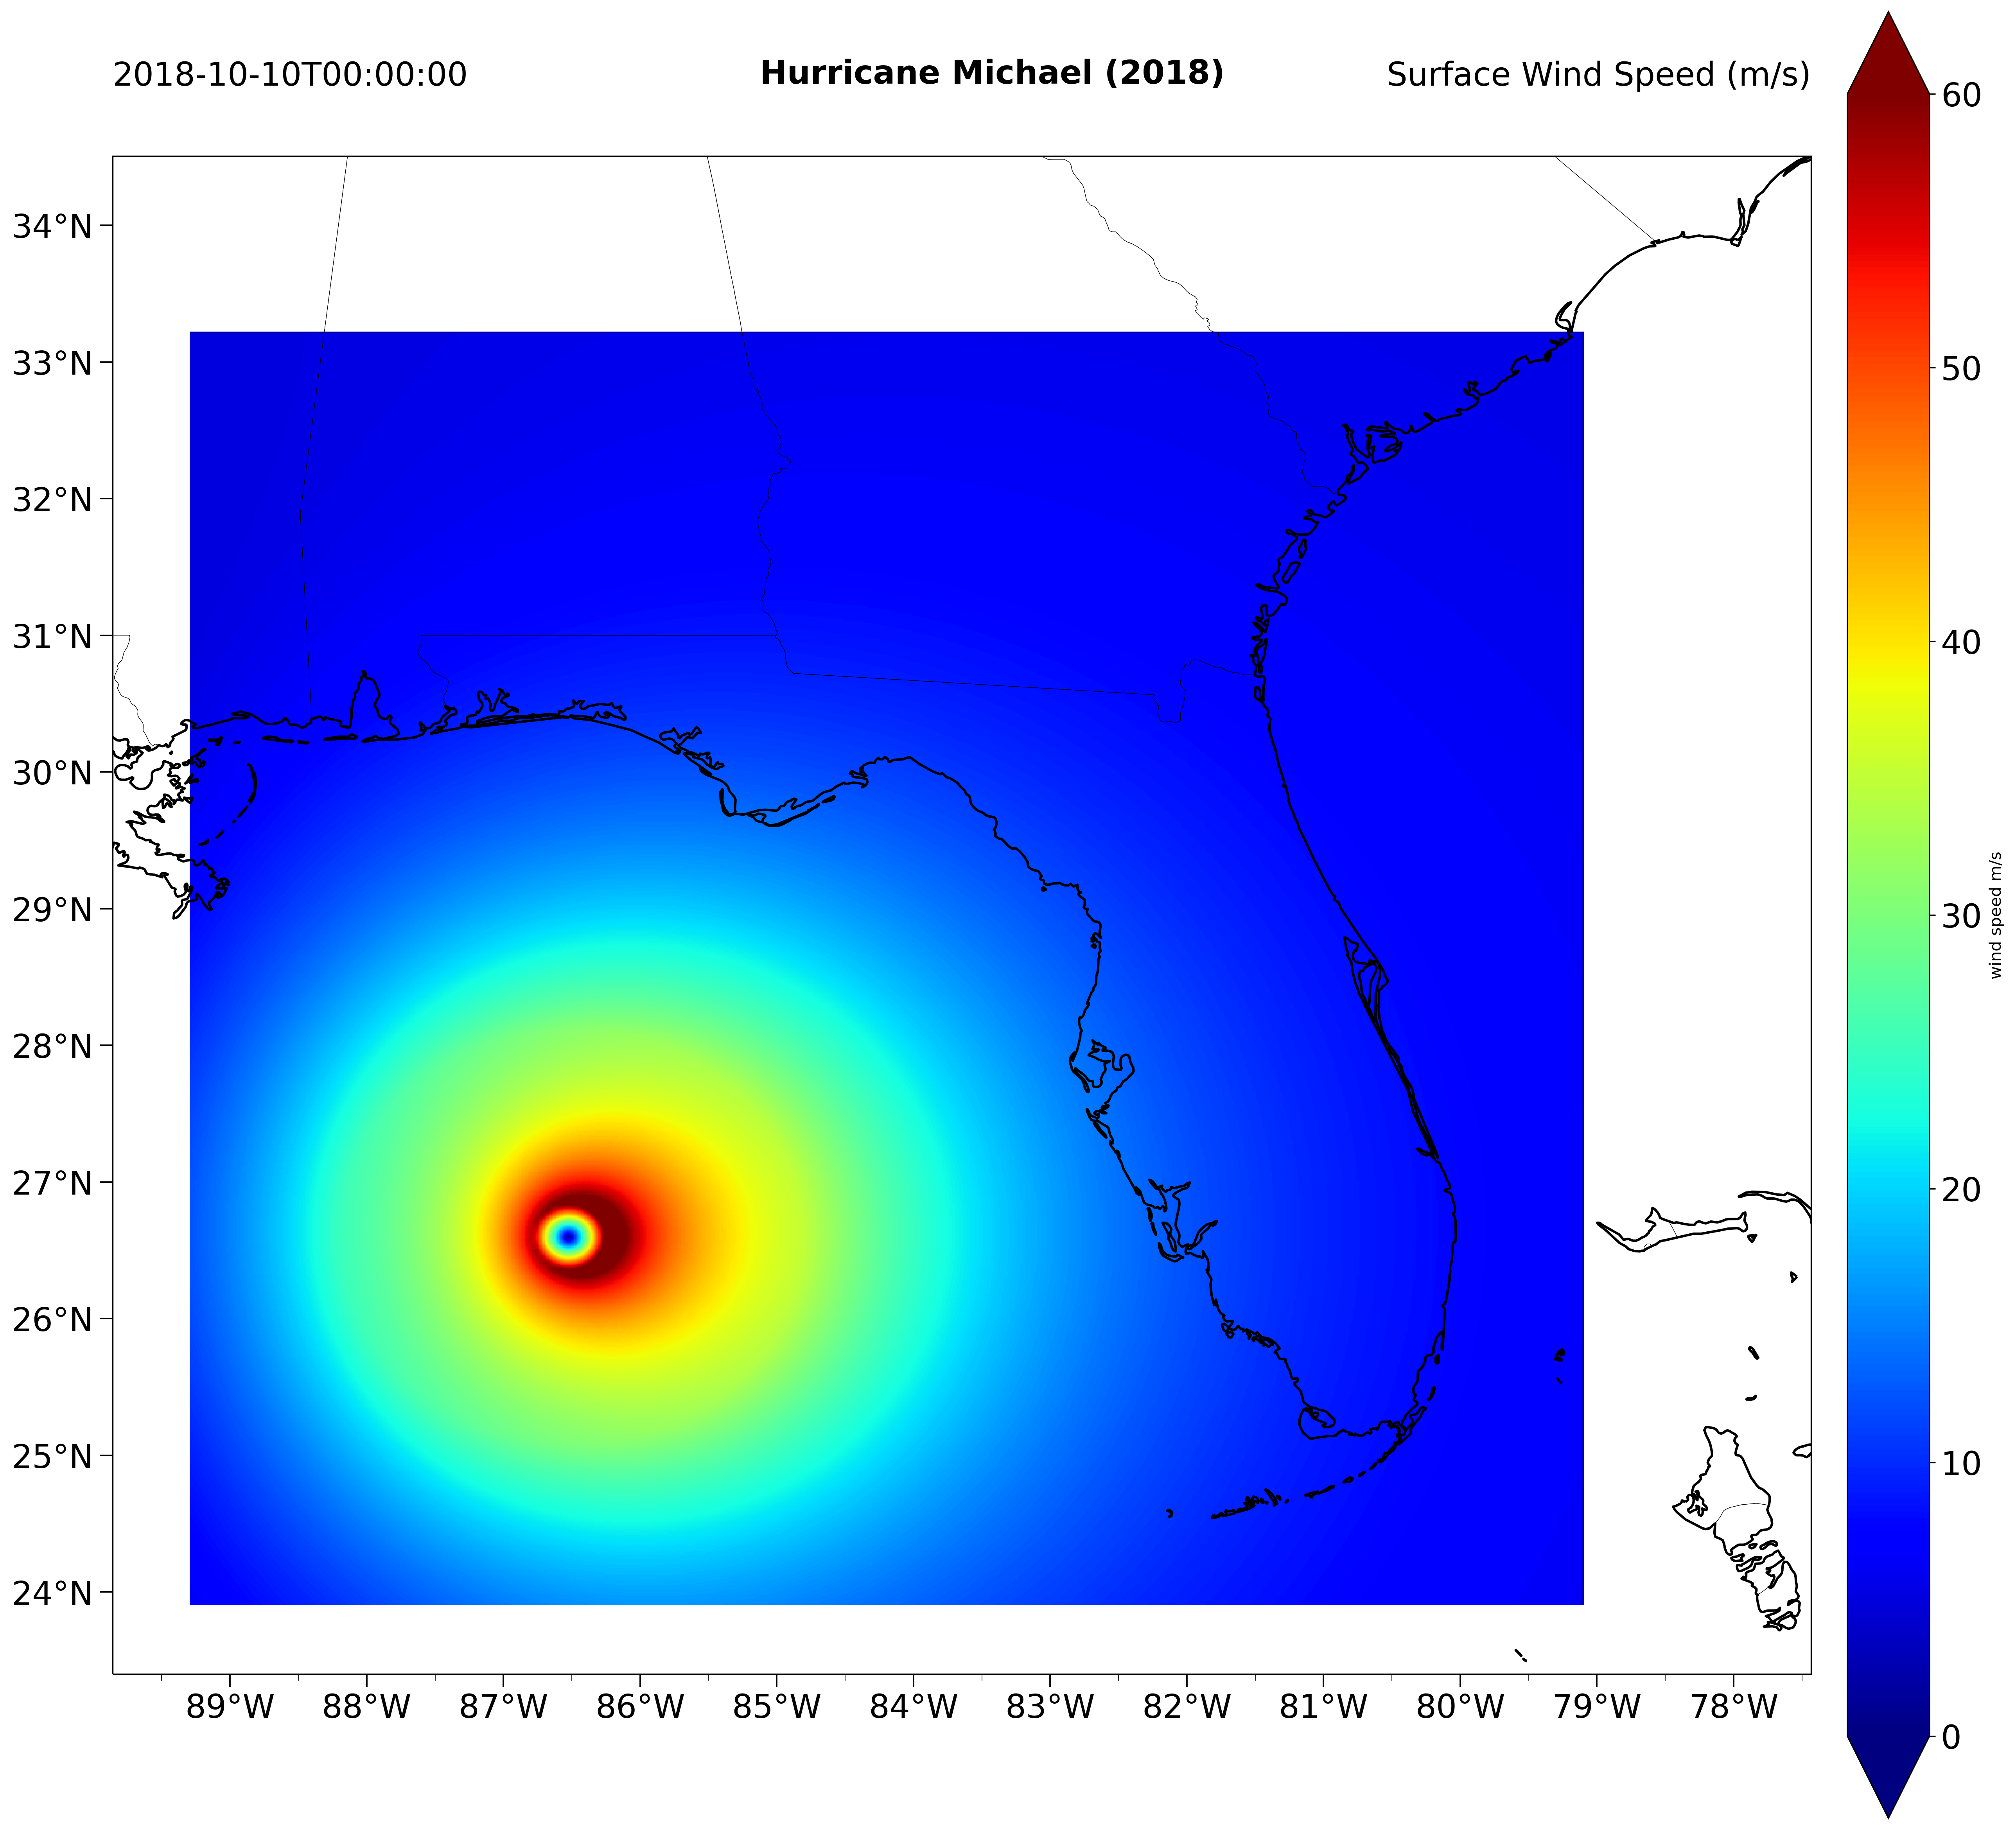

In [12]:
from IPython.display import Image
Image('images/00:00.png')

### <font style="Times New Roman" style="font-size:24px" color='red'> Use ImageMagick to make animated GIF from the sequence of PNGs </font>

In [13]:
! /usr/bin/convert -delay 14 -loop 0 /projects/ees/dhs-crc/mjisan/NCL_HBL/CTD/a11_nc_ctd/GEOCAT/FINAL_VERSIONS/images/*.png -scale 1000x1000 animation.gif

In [ ]:
Image('animation.gif')